# Overview

## Method

## Authors

[Yung Han Jeong](https://github.com/yunghanjeong) <br>
[Malcolm Katzenbach](https://github.com/malcolm206)

In [142]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

import os
import numpy as np
import pickle
import json
import pandas as pd
pd.set_option('display.max_columns', 200) #set to show all columns
pd.set_option('display.max_rows', 200) 

In [7]:
df = pd.read_csv(r"..\data\diabetic_data_dummy.csv", index_col=0)
df.head()

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,readmitted,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,metformin_Down,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_Steady,glyburide-metformin_Up,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,diag_1_circulatory,diag_1_diabetes,diag_1_digestive,diag_1_genitourinary,diag_1_injury,diag_1_musculoskeletal,diag_1_neoplasms,diag_1_respiratory,diag_2_circulatory,diag_2_diabetes,diag_2_digestive,diag_2_genitourinary,diag_2_injury,diag_2_musculoskeletal,diag_2_neoplasms,diag_2_respiratory,diag_3_circulatory,diag_3_diabetes,diag_3_digestive,diag_3_genitourinary,diag_3_injury,diag_3_musculoskeletal,diag_3_neoplasms,diag_3_respiratory
0,1,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,59,0,18,0,0,0,9,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,11,5,13,2,0,1,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,44,1,16,0,0,0,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,51,0,8,0,0,0,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Class Imbalance

In [8]:
df.groupby("readmitted").gender.count()
# 0 = Not Readmitted
# 1 = Readmitted in <30 days
# 2 = Readmitted in >30 days

readmitted
0    54861
1    11357
2    35545
Name: gender, dtype: int64

In [9]:
no_read = df[df.readmitted == 0] # 0 = Not Readmitted
read_1 = df[df.readmitted == 1] # 1 = Readmitted in <30 days
read_2 = df[df.readmitted == 2] # 2 = Readmitted in >30 days

In [10]:
read_1_resample = resample(read_1,
                          replace=True, # sample with replacement
                          n_samples=no_read.shape[0], # match number in majority class
                          random_state=42) # reproducible result

read_2_resample = resample(read_2,
                          replace=True, # sample with replacement
                          n_samples=no_read.shape[0], # match number in majority class
                          random_state=42) # reproducible result

In [11]:
resampled_df = pd.concat([no_read, read_1_resample, read_2_resample])

In [12]:
resampled_df.groupby("readmitted").gender.count()
# 0 = Not Readmitted
# 1 = Readmitted in <30 days
# 2 = Readmitted in >30 days

readmitted
0    54861
1    54861
2    54861
Name: gender, dtype: int64

## Initial Data Split

In [13]:
# split features and predictant
y = resampled_df.readmitted
X = resampled_df.drop(columns = "readmitted")
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Baseline DummyClassifier

In [18]:
dummy_clf = DummyClassifier(strategy="uniform")

In [19]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [20]:
y_pred = dummy_clf.predict(X_test)

In [22]:
dummy_recall = recall_score(y_test, y_pred, average="micro")
print("Dummy Classifier recall: ", dummy_recall)

Dummy Classifier recall:  0.33220726194526806


## Decision Tree - Basic

In [148]:
tree_clf = DecisionTreeClassifier()

In [149]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [150]:
y_tree_pred = tree_clf.predict(X_test)

In [26]:
tree_recall = recall_score(y_test, y_tree_pred, average="micro")
print("Decision Tree recall: ", tree_recall)

Decision Tree recall:  0.7866378262771594


In [29]:
# overfit check
y_tree_train_pred = tree_clf.predict(X_train)
tree__train_recall = recall_score(y_train, y_tree_train_pred, average="micro")
print("Check for Overfitting")
print("Decision Tree Train recall: ", tree__train_recall)
print("Decision Tree Test recall: ", tree_recall)

Check for Overfitting
Decision Tree Train recall:  0.9999837974027237
Decision Tree Test recall:  0.7866378262771594


## Decision Tree - GridSearch

In [33]:
resampled_df.shape[1]/2

72.5

In [30]:
tree_clf = DecisionTreeClassifier()

In [70]:
tree_param = {"max_depth":range(15,31,5),
              "min_samples_split":range(25,101,25),
              "max_features":range(10, 41, 5)
              }

In [71]:
grid_tree = GridSearchCV(tree_clf, param_grid=tree_param, cv=10, scoring="recall_micro", n_jobs=-1, verbose=1)

In [72]:
grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  6.2min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(15, 31, 5),
                         'max_features': range(10, 41, 5),
                         'min_samples_split': range(25, 101, 25)},
             scoring='recall_micro', verbose=1)

In [73]:
grid_tree.best_params_

{'max_depth': 30, 'max_features': 40, 'min_samples_split': 25}

In [74]:
# Initial Check
y_tree_train_pred = grid_tree.best_estimator_.predict(X_train)
y_tree_test_pred = grid_tree.best_estimator_.predict(X_test)
grid_tree_train_recall = recall_score(y_train, y_tree_train_pred, average="micro")
grid_tree_test_recall = recall_score(y_test, y_tree_test_pred, average="micro")
print("Check for Overfitting")
print("Decision Tree Train recall: ", grid_tree_train_recall)
print("Decision Tree Test recall: ", grid_tree_test_recall)

Check for Overfitting
Decision Tree Train recall:  0.7177102489529071
Decision Tree Test recall:  0.6039226170223108


#### Checking for Overfitting

In [75]:
n = 100 # of iteration
# value intialization
train_recall_sum = 0
test_recall_sum = 0
# f1 is same as recall when using micro as average value

for i in range(0, n): 
    # new split
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #predict on new split
    y_tree_train_pred = grid_tree.best_estimator_.predict(X_train)
    y_tree_test_pred = grid_tree.best_estimator_.predict(X_test)
    
    #calculate recall score on new prediction
    train_recall_sum += recall_score(y_train, y_tree_train_pred, average="micro")
    test_recall_sum += recall_score(y_test, y_tree_test_pred, average="micro")
    #f1
    # print("Predicted", i+1, "times") #sanity check

# output average    
print(f"Check for Overfitting with {n} iterations")
print("Decision Tree Train recall: ", train_recall_sum/n)
print("Decision Tree Test recall: ", test_recall_sum/n)

Predicted 1 times
Predicted 2 times
Predicted 3 times
Predicted 4 times
Predicted 5 times
Predicted 6 times
Predicted 7 times
Predicted 8 times
Predicted 9 times
Predicted 10 times
Predicted 11 times
Predicted 12 times
Predicted 13 times
Predicted 14 times
Predicted 15 times
Predicted 16 times
Predicted 17 times
Predicted 18 times
Predicted 19 times
Predicted 20 times
Predicted 21 times
Predicted 22 times
Predicted 23 times
Predicted 24 times
Predicted 25 times
Predicted 26 times
Predicted 27 times
Predicted 28 times
Predicted 29 times
Predicted 30 times
Predicted 31 times
Predicted 32 times
Predicted 33 times
Predicted 34 times
Predicted 35 times
Predicted 36 times
Predicted 37 times
Predicted 38 times
Predicted 39 times
Predicted 40 times
Predicted 41 times
Predicted 42 times
Predicted 43 times
Predicted 44 times
Predicted 45 times
Predicted 46 times
Predicted 47 times
Predicted 48 times
Predicted 49 times
Predicted 50 times
Predicted 51 times
Predicted 52 times
Predicted 53 times
Pr

#### Checking Feature Importance

In [153]:
feature_imp = dict(zip(X.columns, grid_tree.best_estimator_.feature_importances_)) #get feature importance
sorted_feature = {k: v for k, v in sorted(feature_imp.items(), key=lambda item: item[1], reverse=True)} #sort descending
feature_df = pd.DataFrame(sorted_feature, index=[0]) # push to dataframe for better visualization
feature_df.transpose()[:40]

,0
num_lab_procedures,0.112748
num_medications,0.083398
number_inpatient,0.071118
time_in_hospital,0.052221
number_diagnoses,0.038031
num_procedures,0.032513
discharge_disposition_id_11,0.021799
number_outpatient,0.021136
number_emergency,0.019285
diag_3_circulatory,0.014016


In [116]:
n = 0.005 #set comparison threshold
feature_imp = dict(zip(X.columns, grid_tree.best_estimator_.feature_importances_))
nozero_feature = {k: v for k, v in sorted(feature_imp.items(), key=lambda item: item[1], reverse=True) if round(v,3) >=n}
print("dictionary length", len(nozero_feature)) #check how many there are in this dictionary
important_features = list(nozero_feature.keys())

dictionary length 62


## GridSearchCV Decision Tree with Select Features

In [117]:
y = resampled_df.readmitted
X = resampled_df[important_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [118]:
tree_param = {"max_depth":range(15,31,5),
              "min_samples_split":range(25,101,25),
              "max_features":range(10, 41, 5)
              }

In [119]:
grid_select_tree = GridSearchCV(tree_clf, param_grid=tree_param, cv=10, scoring="recall_micro", n_jobs=-1, verbose=1)

In [120]:
grid_select_tree.fit(X_train, y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  5.9min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(15, 31, 5),
                         'max_features': range(10, 41, 5),
                         'min_samples_split': range(25, 101, 25)},
             scoring='recall_micro', verbose=1)

In [121]:
grid_select_tree.best_params_

{'max_depth': 30, 'max_features': 40, 'min_samples_split': 25}

In [122]:
# Initial Check
y_tree_train_pred = grid_select_tree.best_estimator_.predict(X_train)
y_tree_test_pred = grid_select_tree.best_estimator_.predict(X_test)
grid_tree_train_recall = recall_score(y_train, y_tree_train_pred, average="micro")
grid_tree_test_recall = recall_score(y_test, y_tree_test_pred, average="micro")
print("Check for Overfitting")
print("Decision Tree Train recall: ", grid_tree_train_recall)
print("Decision Tree Test recall: ", grid_tree_test_recall)

Check for Overfitting
Decision Tree Train recall:  0.7627858745756945
Decision Tree Test recall:  0.6274972050746124


In [123]:
n = 100 # of iteration
# value intialization
train_recall_sum = 0
test_recall_sum = 0
# f1 is same as recall when using micro as average value

for i in range(0, n): 
    # new split
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #predict on new split
    y_tree_train_pred = grid_select_tree.best_estimator_.predict(X_train)
    y_tree_test_pred = grid_select_tree.best_estimator_.predict(X_test)
    
    #calculate recall score on new prediction
    train_recall_sum += recall_score(y_train, y_tree_train_pred, average="micro")
    test_recall_sum += recall_score(y_test, y_tree_test_pred, average="micro")
    #f1
    # print("Predicted", i+1, "times") #sanity check

# output average    
print(f"Check for Overfitting with {n} iterations")
print("Decision Tree Train recall: ", train_recall_sum/n)
print("Decision Tree Test recall: ", test_recall_sum/n)

Check for Overfitting with 100 iterations
Decision Tree Train recall:  0.7289588210990222
Decision Tree Test recall:  0.7289775433821025


## Fit Whole Data to Model

In [ ]:
tree_clf

[Text(233.2095031964146, 215.53263157894736, 'X[7] <= 0.5\ngini = 0.667\nsamples = 123437\nvalue = [41234, 41109, 41094]'),
 Text(168.4225881515366, 211.7178947368421, 'X[37] <= 0.5\ngini = 0.656\nsamples = 75479\nvalue = [31287, 20697, 23495]'),
 Text(121.3614275506405, 207.90315789473684, 'X[27] <= 0.5\ngini = 0.654\nsamples = 73154\nvalue = [30737, 19305, 23112]'),
 Text(121.34560868472808, 204.0884210526316, 'X[8] <= 6.5\ngini = 0.655\nsamples = 72435\nvalue = [30018, 19305, 23112]'),
 Text(54.97387271861375, 200.2736842105263, 'X[19] <= 0.5\ngini = 0.627\nsamples = 23921\nvalue = [11786, 5410, 6725]'),
 Text(42.94719291419432, 196.45894736842104, 'X[48] <= 0.5\ngini = 0.619\nsamples = 21967\nvalue = [11103, 4612, 6252]'),
 Text(29.284831977132683, 192.6442105263158, 'X[21] <= 0.5\ngini = 0.603\nsamples = 11747\nvalue = [6323, 2504, 2920]'),
 Text(24.98296751883917, 188.8294736842105, 'X[15] <= 0.5\ngini = 0.599\nsamples = 11487\nvalue = [6245, 2356, 2886]'),
 Text(17.5086500151983

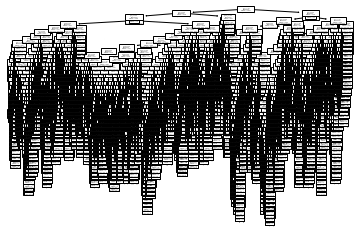

In [152]:
tree.plot_tree(tree_clf)

## Export DecisionTree Related Information

### Model Pickle

In [125]:
with open(r"..\model\best_feature_tree.pickle", "wb") as feat_tree:
    pickle.dump(grid_select_tree.best_estimator_, feat_tree)

### Feature Importance DataFrame

In [126]:
feature_df.to_csv(r"..\model\decision_tree_feature_score.csv")

### Important Features List

In [128]:
dt_feature_dict = {"features":important_features}

In [130]:
with open(r"..\model\dt_features.json", "w") as dt_features:  
    json.dump(dt_feature_dict, dt_features) 

## Radom Forrest Classifier - Basic

In [131]:
rf_clf = RandomForestClassifier()

In [132]:
# split features and predictant
y = resampled_df.readmitted
X = resampled_df.drop(columns = "readmitted")
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [136]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [134]:
# overfit check
#make prediction
y_rf_train_pred = rf_clf.predict(X_train)
y_rf_test_pred = rf_clf.predict(X_test)
# get recall score
rf_train_recall = recall_score(y_train, y_rf_train_pred, average="micro")
rf_test_recall = recall_score(y_test, y_rf_test_pred, average="micro")

print("Check for Overfitting")
print("Decision Tree Train recall: ", rf_train_recall)
print("Decision Tree Test recall: ", rf_test_recall)

Check for Overfitting
Decision Tree Train recall:  0.9999837974027237
Decision Tree Test recall:  0.8611043600836047


In [137]:
n = 100 # # of iteration
avg_rf_test_recall = 0
avg_rf_train_recall = 0

for i in range(0, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    y_rf_train_pred = rf_clf.predict(X_train)
    y_rf_test_pred = rf_clf.predict(X_test)
    # get recall score
    avg_rf_test_recall += recall_score(y_train, y_rf_train_pred, average="micro")
    avg_rf_train_recall += recall_score(y_test, y_rf_test_pred, average="micro")
    print(i)

print("Check for Overfitting")
print("Random Forrest Train recall: ", avg_rf_train_recall/n)
print("Random Forrest Test recall: ", avg_rf_test_recall/n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Check for Overfitting
Decision Tree Train recall:  0.9642632273953512
Decision Tree Test recall:  0.9642793953239684


In [141]:
rf_clf.feature_importances_ 

array([2.31354918e-02, 5.91955883e-02, 9.18297705e-02, 4.06354182e-02,
       8.20092295e-02, 1.79497450e-02, 1.36685206e-02, 4.18355784e-02,
       4.19650693e-02, 1.43361609e-02, 9.47315556e-03, 1.34990331e-02,
       9.38525408e-03, 4.29465794e-05, 4.18313620e-03, 4.86847191e-03,
       1.84160174e-05, 6.21552563e-04, 4.41043100e-03, 9.24033836e-03,
       1.84801770e-03, 2.96971324e-03, 9.78898495e-03, 1.56643347e-03,
       3.32258840e-04, 6.98271762e-05, 8.00450377e-06, 8.67521831e-03,
       8.44043422e-06, 1.04516843e-03, 1.15299538e-03, 4.86501824e-04,
       1.60389274e-05, 8.63006910e-06, 4.91108868e-03, 5.32606399e-06,
       2.08643006e-06, 6.03881287e-03, 7.93627785e-04, 1.52913484e-04,
       1.31000578e-03, 7.03049850e-06, 7.25459940e-04, 1.91346162e-03,
       5.31027883e-04, 3.19079481e-03, 1.44768599e-03, 2.18917877e-03,
       1.29398532e-02, 5.57379061e-05, 2.66856683e-04, 1.63091632e-05,
       2.73434015e-06, 0.00000000e+00, 1.54671240e-06, 4.54582655e-03,
      